In [ ]:
import random
import folium
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Section

In [ ]:
def get_data():
    nodes = ["Los Angeles", "Atlanta", "Miami", "New York", "Chicago", "Seattle", "Vancouver", "Toronto", "Salt Lake City", "Denver", "Dallas", "Kansas City", "Memphis", "Nashville", "Columbus", "Calgary", "Regina", "Winnipeg"]

    nodes_coordinates = {
		"Los Angeles": { "lat": 34.052235, "long": -118.24368 },
		"Atlanta": { "lat": 33.753746, "long": -84.386330 },
		"Miami": { "lat": 25.761681, "long": -80.191788 },
		"New York": { "lat": 40.730610, "long": -73.935242 },
		"Chicago": { "lat": 41.881832, "long": -87.623177 },
		"Seattle": { "lat": 47.608013, "long": -122.335167 },
		"Vancouver": { "lat": 49.246292, "long": -123.116226 },
		"Toronto": { "lat": 43.651070, "long": -79.347015 },
		"Salt Lake City": { "lat": 40.758701, "long":-111.876183 },
		"Denver": { "lat": 39.742043, "long": -104.991531 },
		"Dallas": { "lat": 32.779167, "long": -96.808891},
		"Kansas City": { "lat": 39.099724, "long": -94.578331 },
		"Memphis": { "lat": 35.117500, "long": -89.971107 },
		"Nashville": { "lat": 36.174465, "long": -86.767960 },
		"Columbus": { "lat": 39.983334, "long": -82.983330 },
		"Calgary": { "lat": 51.049999, "long": -114.066666 },
		"Regina": { "lat": 50.445210, "long": -104.618896 },
		"Winnipeg": { "lat": 49.895077, "long": -97.138451 }
	}

    cost_matrix = generate_costs(nodes_coordinates, nodes)
    return nodes, nodes_coordinates, cost_matrix

In [ ]:
def generate_costs(nodes_coordinates, nodes):
  node_cost = []

  for x in nodes_coordinates:
    result = []
    node1 = nodes_coordinates[x]

    for y in nodes_coordinates:
      node2 = nodes_coordinates[y]

      distance = np.sqrt( (node2["lat"] - node1["lat"])  ** 2 + (node2["long"] - node1["long"]) ** 2 )
      distance = distance if distance < 30 else np.inf
      result.append(distance)

    node_cost.append(result)


  cost_matrix = pd.DataFrame(node_cost, index=nodes, columns=nodes)
  return cost_matrix

In [ ]:
def generate_route(nodes):
  origin = random.sample(nodes, 1)[0]
  destination = random.sample(nodes, 1)[0]

  while (origin == destination):
    destination = random.sample(nodes, 1)

  return origin, destination

# Genetic Section


In [ ]:
def initial_population(nodes, origin, destination, POPULATION_SIZE):
  population = []
  shortest_path = {}

  shortest_path['path'] = [origin, destination]
  population.append(shortest_path)

  for _ in range(POPULATION_SIZE):
    filtered_nodes = [node for node in nodes if node != origin and node != destination]

    individual = {}
    intermediates = random.randint(0, len(filtered_nodes))
    path = random.sample(filtered_nodes, intermediates)
    path.insert(0, origin)
    path.append(destination)
    individual['path'] = path
    population.append(individual)

  return population

In [ ]:
def evaluate(population, cost):
  lowest_cost = None
  best_solution = None

  for index, individual in enumerate(population):
    total_cost = 0

    for location in range(len(individual['path'])-1):
      node = individual['path'][location]
      next_node = individual['path'][location+1]
      total_cost += cost.loc[node, next_node]

    individual['cost'] = total_cost

    if lowest_cost is None or lowest_cost > total_cost:
      lowest_cost = total_cost
      best_solution = index

  return population, lowest_cost, best_solution

In [ ]:
def tournament(population):
  parents = []
  tournament_participants = random.sample(population, 5)

  while len(parents) < 2:
    winner = min(tournament_participants, key=lambda x: x['cost'])
    tournament_participants.remove(winner)
    parents.append(winner)

  return parents

In [ ]:
def crossover(parents):
  origin = parents[0]['path'][0]
  destination = parents[0]['path'][-1]

  parent1 = parents[0]
  parent2 = parents[1]

  length_parent1 = len(parent1)
  length_parent2 = len(parent2)

  child1 = {}
  child2 = {}

  if min(length_parent1, length_parent2) > 2:

    if min(length_parent1, length_parent2) == 3:
      index = random.randint(0, min(length_parent1, length_parent2) -2)
      path_child1 = parent1 + parent2[index:]
      path_child2 = parent2 + parent1[index:]

    else:
      index = random.randint(1, min(length_parent1, length_parent2) - 2)
      path_child1 = parent1[:index] + parent2[index:]
      path_child2 = parent2[:index] + parent1[index:]

    path_child1 = fix_path(path_child1, origin, destination)
    path_child2 = fix_path(path_child2, origin, destination)

    child1['path'] = path_child1
    child2['path'] = path_child2

    return [child1, child2]

  else:
    return parents

In [ ]:
def fix_path(path, origin, destination):

  if (path[0] != origin):
    path[0] = origin

  if (path[-1] != destination):
    path[-1] = destination

  path = list(dict.fromkeys(path))

  return path

In [ ]:
def generate_child(population):
    parents = tournament(population)
    child = crossover(parents)
    return child

In [ ]:
def mutation(path, nodes, origin, destination):
  mutated_path = path.copy()
  length = len(mutated_path)
  filtered_nodes = [node for node in nodes if node != origin and node != destination]

  if length == 2 or length == 3:
    node_chosen = random.sample(filtered_nodes, 1)
    mutated_path.insert(1, node_chosen[0])

  elif length > 3:
    mutated_path.pop(random.randint(1, length-1))

  mutated_path = fix_path(mutated_path, origin, destination)
  mutated = {}
  mutated['path'] = mutated_path

  return mutated

# Main Section

In [ ]:
POPULATION_SIZE=10
GENERATIONS=100
nodes, nodes_coodinates, cost_matrix = get_data()

cost_matrix

,Los Angeles,Atlanta,Miami,New York,Chicago,Seattle,Vancouver,Toronto,Salt Lake City,Denver,Dallas,Kansas City,Memphis,Nashville,Columbus,Calgary,Regina,Winnipeg
Los Angeles,0.000000,inf,inf,inf,inf,14.159780,15.956224,inf,9.247795,14.421975,21.472561,24.197642,28.292635,inf,inf,17.503469,21.315824,26.389891
Atlanta,inf,0.000000,9.025923,12.565901,8.748883,inf,inf,11.106382,28.368317,21.457726,12.460731,11.508969,5.748875,3.395886,6.385623,inf,26.229024,20.570833
Miami,inf,9.025923,0.000000,16.223847,17.750628,inf,inf,17.909324,inf,28.468891,18.038105,19.618257,13.533899,12.315523,14.493037,inf,inf,29.489154
New York,inf,12.565901,16.223847,0.000000,13.736261,inf,inf,6.149502,inf,inf,24.216302,20.707412,16.989878,13.617529,9.078894,inf,inf,24.947472
Chicago,inf,8.748883,17.750628,13.736261,0.000000,inf,inf,8.463159,24.278998,17.499669,12.931970,7.490947,7.160235,5.771086,5.013230,27.987737,19.031182,12.439957
Seattle,14.159780,inf,inf,inf,inf,0.000000,1.814941,inf,12.502137,19.044033,29.520932,29.031585,inf,inf,inf,8.956304,17.942016,25.300300
Vancouver,15.956224,inf,inf,inf,inf,1.814941,0.000000,inf,14.084664,20.465466,inf,inf,inf,inf,inf,9.227562,18.536144,25.985875
Toronto,inf,11.106382,17.909324,6.149502,8.463159,inf,inf,0.000000,inf,25.940734,20.569769,15.896784,13.626927,10.534232,5.164792,inf,26.169224,18.855313
Salt Lake City,9.247795,28.368317,inf,inf,24.278998,12.502137,14.084664,inf,0.000000,6.959312,17.049817,17.377223,22.619803,25.523285,28.903255,10.521836,12.103581,17.339957
Denver,14.421975,21.457726,28.468891,inf,17.499669,19.044033,20.465466,25.940734,6.959312,0.000000,10.744172,10.432991,15.716219,18.569495,22.009524,14.499239,10.709652,12.835691


In [ ]:
current_generation = 1
origin = "Los Angeles"
destination = "New York"

solutions = []
costs = []

population = initial_population(nodes, origin, destination, POPULATION_SIZE)

while current_generation < GENERATIONS:
	population, lowest_cost, best_solution = evaluate(population, cost_matrix)

	costs.append(lowest_cost)

	solutions.append(population[best_solution])

	print(f"Generation {current_generation} - Lowest cost: {lowest_cost}")

	new_population = []
	new_population.append(population[best_solution])

	while len(new_population) < POPULATION_SIZE:
		child = generate_child(population)
		for x in child:
			mutated_child = mutation(x['path'], nodes, origin, destination)
			new_population.append(x)
			new_population.append(mutated_child)

	population = new_population
	current_generation += 1

Generation 1 - Lowest cost: 77.4223856051668
Generation 2 - Lowest cost: 70.98697663385748
Generation 3 - Lowest cost: 52.20513832199934
Generation 4 - Lowest cost: 52.20513832199934
Generation 5 - Lowest cost: 45.28251307930843
Generation 6 - Lowest cost: 45.28251307930843
Generation 7 - Lowest cost: 45.28251307930843
Generation 8 - Lowest cost: 45.28251307930843
Generation 9 - Lowest cost: 45.28251307930843
Generation 10 - Lowest cost: 45.28251307930843
Generation 11 - Lowest cost: 45.28251307930843
Generation 12 - Lowest cost: 45.28251307930843
Generation 13 - Lowest cost: 45.28251307930843
Generation 14 - Lowest cost: 45.28251307930843
Generation 15 - Lowest cost: 45.28251307930843
Generation 16 - Lowest cost: 45.28251307930843
Generation 17 - Lowest cost: 45.28251307930843
Generation 18 - Lowest cost: 45.28251307930843
Generation 19 - Lowest cost: 45.28251307930843
Generation 20 - Lowest cost: 45.28251307930843
Generation 21 - Lowest cost: 45.28251307930843
Generation 22 - Lowest 

# Map Section

In [ ]:
def show(nodes_coordinates, solutions, origin, destination, best_solution):
	map = folium.Map(location=[41, -80], zoom_start=5)

	for node, coordinates in nodes_coordinates.items():
		if node == origin:
			folium.Marker([coordinates['lat'], coordinates['long']], popup=node, icon=folium.Icon(color="red")).add_to(map)
		elif node == destination:
			folium.Marker([coordinates['lat'], coordinates['long']], popup=node, icon=folium.Icon(color="green")).add_to(map)
		else:
			folium.Marker([coordinates['lat'], coordinates['long']], popup=node).add_to(map)

		for index, city in enumerate(best_solution['path']):
			if index < len(best_solution['path'])-1:
				location1 = [nodes_coodinates[city]['lat'], nodes_coodinates[city]['long']]
				location2 = [nodes_coodinates[best_solution['path'][index+1]]['lat'], nodes_coodinates[best_solution['path'][index+1]]['long']]

				line = folium.PolyLine(locations=[location1, location2], weight=2, color="#FF0000")
				#else:
					#line = folium.PolyLine(locations=[location1, location2], weight=2, color="#000")

				map.add_child(line)

	return map

In [ ]:
population[best_solution]['path']

['Los Angeles', 'Kansas City', 'New York']

In [ ]:
map = show(nodes_coodinates, solutions, origin, destination, population[best_solution])
map

# Graph Section

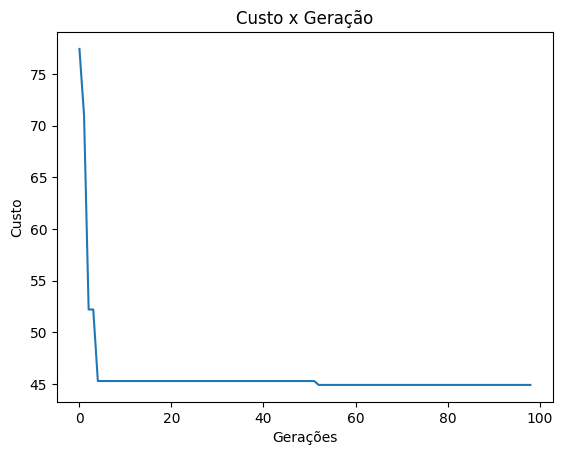

In [ ]:
plt.plot(costs)
plt.xlabel("Gerações")
plt.ylabel("Custo")
plt.title("Custo x Geração")
plt.show()